- 장르간 상관관계 분석

In [3]:
# module
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

In [4]:
# Util Functions
from enum import Enum

# 파일을 읽어와 pandas의 DataFrame으로 반환해줌
def get_df_from(path: str, sep: str = ','):
    extension = path.split('.')[-1]
    try:
        if extension == "csv" or extension == "txt":
            df = pd.read_csv(path, sep=sep, on_bad_lines='skip')
            if df.empty:
                print("W: DataFrame is empty.")
                return None
            return df
        else:
            print("E: File extension is not supported.")
            return None
    except FileNotFoundError:
        print(f"E: File not found. Check the path: {path}")
        return None
    except pd.errors.ParserError as e:
        print(f"E: Error parsing CSV file: {e}")
        return None
    except Exception as e:
        print(f"E: An unexpected error occured: {e}")
        return None

# 리스트의 평균을 반환.(기본값 0)
def calculate_mean(lst):
    if lst: # 빈 리스트가 아닌 경우에만 평균 계산
        return np.mean(lst)
    return 0 # 빈 리스트인 경우 NaN 반환

# 리스트의 합을 반환.(기본값 0)
def calculate_sum(lst):
    if lst:
        return np.sum(lst)
    return 0


class ChartShape(Enum):
    BAR = 1
    HISTOGRAM = 2
    LINE = 3
    HEATMAP = 4

# Chart 뽑는 함수
def get_chart_from(df: pd.DataFrame, x_col: str, y_col: str, shape: ChartShape = ChartShape.BAR, real_time: bool = False):
    plt.figure(figsize=(10, 6))
    if shape == ChartShape.BAR:
        plt.bar(df[x_col], df[y_col])
    elif shape == ChartShape.HISTOGRAM:
        plt.hist(df[x_col], bins=10)
    elif shape == ChartShape.LINE:
        plt.plot(df[x_col], df[y_col])
    else:
        plt.plot(df[x_col], df[y_col])

    if real_time:
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) # 월 단위로 큰 눈금 표시
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # 날짜 형식 지정
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(df[x_col], rotation=45, ha='right')
    plt.show()

def get_chart_from_series(sr: pd.Series, x_col: str, y_col: str, shape: ChartShape = ChartShape.BAR):
    if shape == ChartShape.BAR:
        sr.plot.bar()
    if shape == ChartShape.LINE:
        sr.plot.line()
    if shape == ChartShape.HISTOGRAM:
        sr.plot.hist()
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

def get_integer(question: str):
    try:
        id = int(input(question))
        return id
    except:
        print(f"E: invalid integer")
        return 0

In [5]:
# Function

folder_path = '../public/kmrd-small/'

file_paths = {
    'castings': folder_path + 'castings.csv',
    'countries': folder_path + 'countries.csv',
    'genres': folder_path + 'genres.csv',
    'movies': folder_path + 'movies.txt',
    'peoples': folder_path + 'peoples.txt',
    'rates': folder_path + 'rates.csv',
}

def get_df_strict_from(path: str, sep: str = ','):
    df = get_df_from(path, sep)
    for _ in range(3):
        if df is not None:
            return df
        new_path = input('오류가 발생했습니다. 정확한 경로를 확인해주세요: ')
        new_sep = input('구분자를 입력해주세요: ')
        df = get_df_from(new_path, new_sep)
    exit()

In [6]:
dfs = {}
names = ['genres', 'rates', 'movies']
for name in names:
    path = file_paths[name]
    if name == 'movies' or name == 'peoples':
        dfs[name] = get_df_strict_from(path, '\t')
    else:
        dfs[name] = get_df_strict_from(path)

dfs['movies']['movie'] = dfs['movies']['movie'].astype(int)

merged_df = pd.merge(dfs['rates'], dfs['movies'], on='movie', how='left')
merged_df = pd.merge(merged_df, dfs['genres'], on='movie', how='left')
merged_df.head(3)

,user,movie,rate,time,title,title_eng,year,grade,genre
0,0,10003,7,1494128040,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF
1,0,10003,7,1494128040,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,코미디
2,0,10004,7,1467529800,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부


In [7]:
print(f"스릴러 영화 개수: {merged_df.value_counts('genre')['스릴러']}")
print(f"공포 영화 개수: {merged_df.value_counts('genre')['공포']}")

print(f"스릴러 영화 개수: {merged_df.value_counts('genre')['스릴러']}")
print(f"미스터리 영화 개수: {merged_df.value_counts('genre')['미스터리']}")

스릴러 영화 개수: 30265
공포 영화 개수: 14407
스릴러 영화 개수: 30265
미스터리 영화 개수: 3450


In [8]:
genre_user_matrix = pd.pivot_table(merged_df, index='user', columns='genre', values='rate', aggfunc='count', fill_value=0)
# cond1 = genre_user_matrix.sum(axis=1) > 5
# genre_user_matrix = genre_user_matrix[cond1]

genre_user_matrix = genre_user_matrix.applymap(lambda x: 1 if x >= 1 else 0)

/tmp/ipykernel_235499/2993779558.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genre_user_matrix = genre_user_matrix.applymap(lambda x: 1 if x >= 1 else 0)


In [9]:
# pearson, spearman, kendall
genre_user_matrix = genre_user_matrix.fillna(0)
genre_correlation = genre_user_matrix.corr(method='kendall', min_periods=None)
print(genre_correlation.head(3))

genre        SF        가족        공포       느와르     다큐멘터리       드라마    멜로/로맨스  \
genre                                                                         
SF     1.000000  0.193682  0.267817  0.055034 -0.004007 -0.275544 -0.080214   
가족     0.193682  1.000000  0.115004  0.086034 -0.002385 -0.123911  0.065045   
공포     0.267817  0.115004  1.000000  0.124284 -0.002783 -0.082831  0.121514   

genre        모험       뮤지컬      미스터리        범죄        서부        서사       스릴러  \
genre                                                                         
SF     0.179076  0.015035  0.118112  0.034454  0.146257  0.043448  0.460986   
가족     0.632042  0.182763  0.123560  0.349751  0.118941  0.073655  0.080008   
공포     0.127451  0.064768  0.307731  0.196199  0.135531  0.080631  0.409534   

genre     애니메이션        액션        에로        전쟁       코미디       판타지  
genre                                                              
SF     0.154569  0.507677  0.034987  0.076769  0.225347  0.234583  
가족  

/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


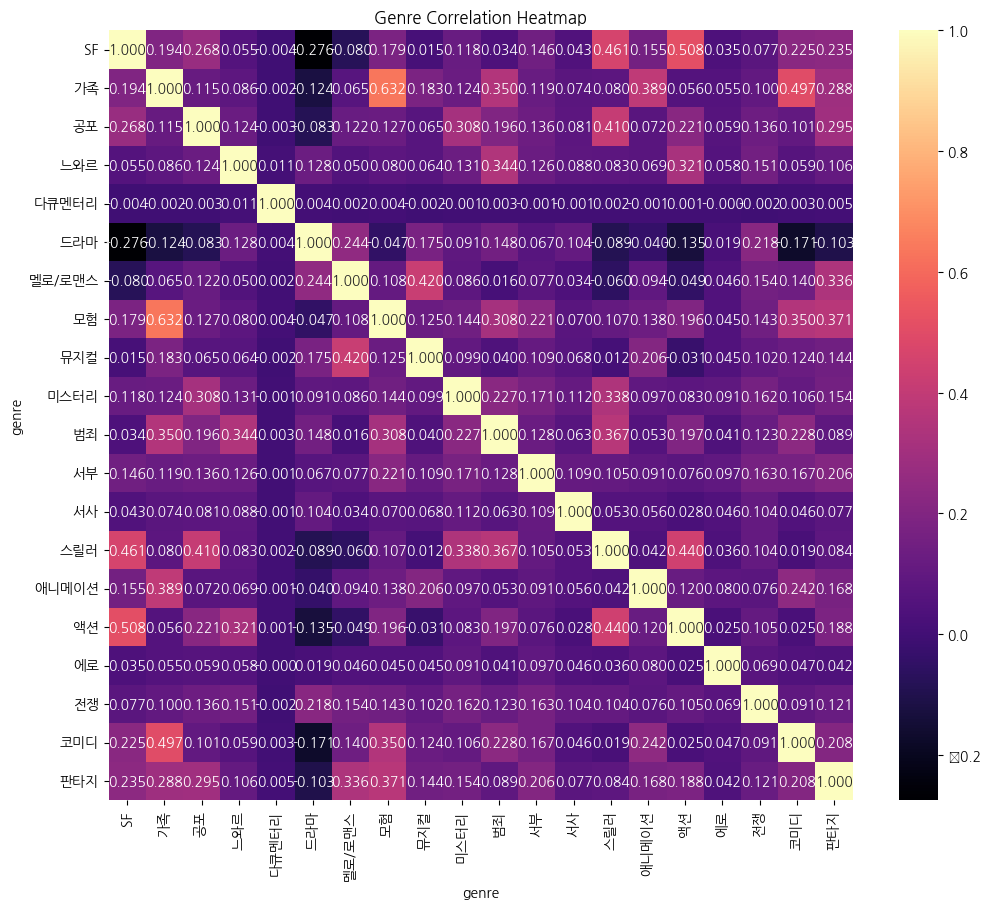

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(genre_correlation, annot=True, cmap='magma', fmt='.3f')
plt.title('Genre Correlation Heatmap')
plt.show()

/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


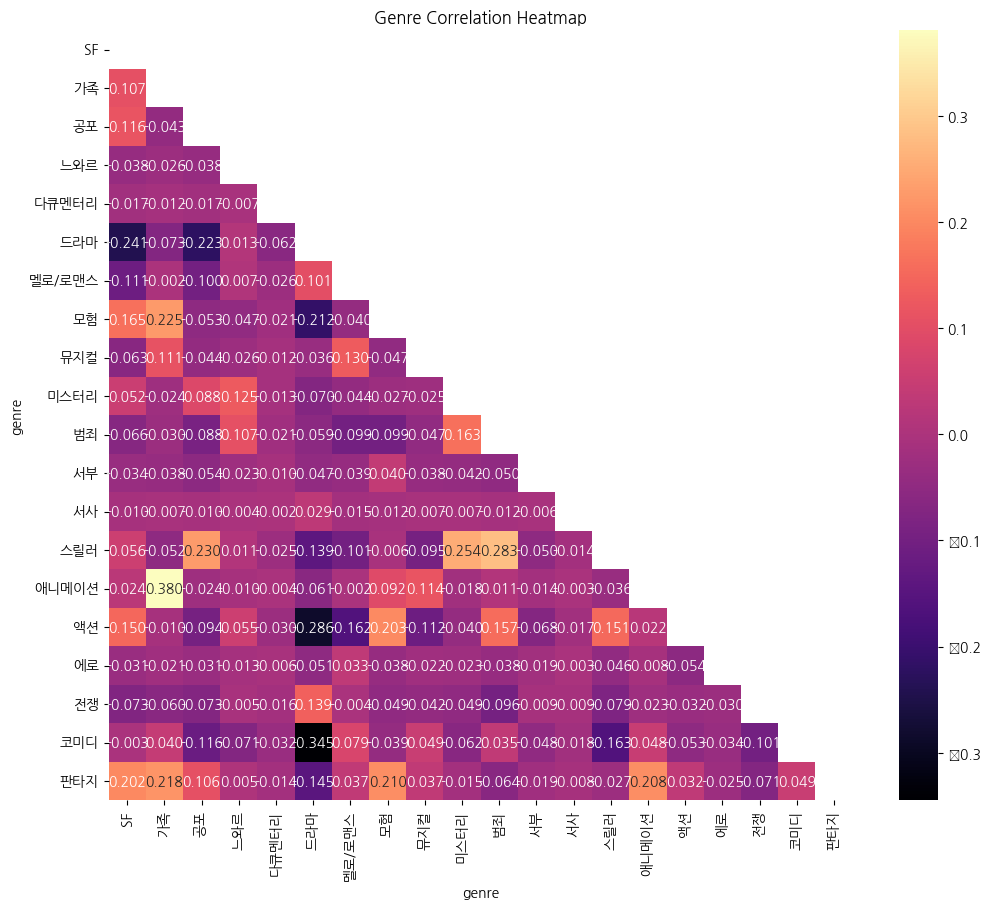

In [ ]:
genres_df = dfs['genres']

genres_df['cnt'] = 1

genres_movies_table = genres_df.pivot_table(index='movie', columns='genre', values='cnt', aggfunc='count')

genres_movies_table = genres_movies_table.fillna(0)

genres_corr = genres_movies_table.corr()


mask = np.triu(np.ones_like(genres_corr, dtype=bool), k=0)

plt.figure(figsize=(12, 10))
sns.heatmap(genres_corr, mask=mask, annot=True, cmap='magma', fmt='.3f')
plt.title('Genre Correlation Heatmap')
plt.show()